In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from lucent.optvis import render, param, transform, objectives

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
model = 'inception_v3'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [5]:
# Load the best model from file
model_ = torch.load(model_file)
model_.to(device).eval()

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

100%|██████████| 512/512 [00:23<00:00, 22.06it/s]



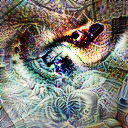

In [37]:
obj = objectives.channel('Mixed_7c_branch3x3dbl_3a', 256)
_ = render.render_vis(model_, obj, show_inline=True)

  1%|          | 4/512 [00:00<00:15, 31.79it/s]

Layer:: Conv2d_4a_3x3


100%|██████████| 512/512 [00:15<00:00, 33.67it/s]



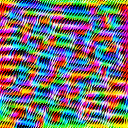

  1%|          | 4/512 [00:00<00:15, 31.97it/s]

Layer:: Mixed_5b


100%|██████████| 512/512 [00:15<00:00, 32.43it/s]



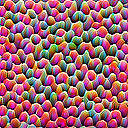

  1%|          | 3/512 [00:00<00:17, 29.34it/s]

Layer:: Mixed_5c


100%|██████████| 512/512 [00:16<00:00, 31.08it/s]



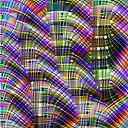

  1%|          | 3/512 [00:00<00:18, 27.19it/s]

Layer:: Mixed_5d


100%|██████████| 512/512 [00:17<00:00, 29.73it/s]



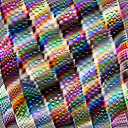

  1%|          | 4/512 [00:00<00:16, 30.36it/s]

Layer:: Mixed_6a


100%|██████████| 512/512 [00:17<00:00, 29.16it/s]



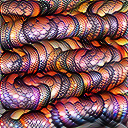

  1%|          | 3/512 [00:00<00:17, 28.53it/s]

Layer:: Mixed_6b


100%|██████████| 512/512 [00:18<00:00, 27.48it/s]



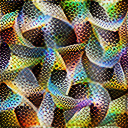

  1%|          | 3/512 [00:00<00:18, 27.17it/s]

Layer:: Mixed_6c


100%|██████████| 512/512 [00:19<00:00, 25.77it/s]



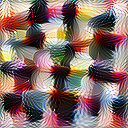

  1%|          | 3/512 [00:00<00:20, 25.19it/s]

Layer:: Mixed_6d


100%|██████████| 512/512 [00:21<00:00, 24.16it/s]



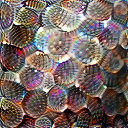

In [30]:
for layer in ['Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b','Mixed_6c','Mixed_6d']:
    print('Layer:: {}'.format(layer))
    obj = objectives.channel(layer, 120)
    _ = render.render_vis(model_, obj, show_inline=True, image_name=layer)

  1%|          | 3/512 [00:00<00:22, 22.77it/s]

Layer:: Mixed_7a


100%|██████████| 512/512 [00:22<00:00, 22.96it/s]



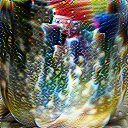

  0%|          | 2/512 [00:00<00:27, 18.75it/s]

Layer:: Mixed_7b


100%|██████████| 512/512 [00:23<00:00, 21.37it/s]



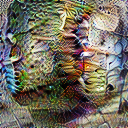

  0%|          | 2/512 [00:00<00:26, 19.43it/s]

Layer:: Mixed_7c


100%|██████████| 512/512 [00:24<00:00, 20.92it/s]



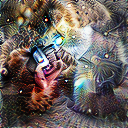

In [31]:
for layer in ['Mixed_7a', 'Mixed_7b','Mixed_7c']:
    print('Layer:: {}'.format(layer))
    obj = objectives.channel(layer, 120)
    _ = render.render_vis(model_, obj, show_inline=True, image_name=layer)

100%|██████████| 512/512 [00:22<00:00, 23.04it/s]



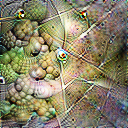

In [34]:
channel = lambda n: objectives.channel("Mixed_7a", n)
obj = channel(203) + channel(542)
_ = render.render_vis(model_, obj, show_inline=True)

100%|██████████| 512/512 [00:21<00:00, 24.19it/s]



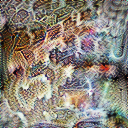

In [35]:
channel = lambda n: objectives.channel("Mixed_7a_branch7x7x3_4", n)
obj = channel(64) + channel(128)
_ = render.render_vis(model_, obj, show_inline=True)

100%|██████████| 512/512 [00:22<00:00, 23.03it/s]



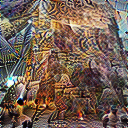

In [51]:
obj = objectives.channel('Mixed_7a', 1024)
_ = render.render_vis(model_, obj, show_inline=True)

100%|██████████| 512/512 [00:19<00:00, 26.62it/s]



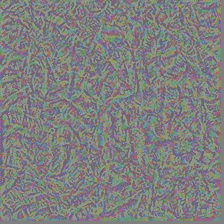

In [52]:
param_f = lambda: param.image(224, fft=False, decorrelate=False)
# We set transforms=[] to denote no transforms
_ = render.render_vis(model_, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:19<00:00, 26.08it/s]



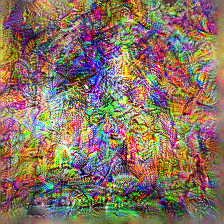

In [53]:
param_f = lambda: param.image(224, fft=True, decorrelate=False)
_ = render.render_vis(model_, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:19<00:00, 25.60it/s]



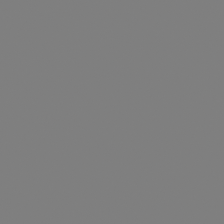

In [54]:
param_f = lambda: param.image(224, fft=False, decorrelate=True)
_ = render.render_vis(model_, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:19<00:00, 26.26it/s]



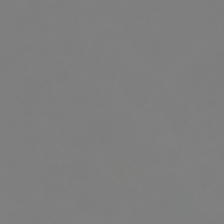

In [55]:
param_f = lambda: param.image(224, fft=True, decorrelate=True)
_ = render.render_vis(model_, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:22<00:00, 22.54it/s]



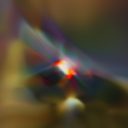

In [56]:
cppn_param_f = lambda: param.cppn(128)
# We initialize an optimizer with lower learning rate for CPPN
cppn_opt = lambda params: torch.optim.Adam(params, 5e-3)
_ = render.render_vis(model_, obj, cppn_param_f, cppn_opt, transforms=[], show_inline=True)

In [71]:
layer = 'Mixed_7a'
neuron = []
batch=0
for i_channel in np.arange(0,2048,250):
    neuron.append( objectives.channel(layer, i_channel, batch=batch) )
    batch += 1
param_f = lambda: param.image(224, batch=batch)

In [75]:
obj = lambda neuron: neuron

In [76]:
_ = render.render_vis(model_, obj, param_f,show_inline=True)

  0%|          | 0/512 [00:00<?, ?it/s]


AttributeError: 'function' object has no attribute 'backward'

In [ ]:
# Get data transforms
data_transforms = makeTransforms()

In [ ]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


In [ ]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [ ]:
# Load model training history
history = unpickle(model_history)

In [ ]:
history.keys()

In [ ]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [ ]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

In [ ]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

In [ ]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))